<a href="https://colab.research.google.com/github/insyspo/scielo/blob/main/SciELO_relational_model_reference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SciELO relational model

Scripts to convert the Scielo database of works into a relational model.

Previous step is to convert the XML files into JSON objects and upload all of them into a single table inside BigQuery with one column containg a JSON string. One work each row.

All the steps can be implemented in a Google BigQuery account. Other data warehouses can be used, with corresponding changes in the SQL scripts and import export steps must also be adapted.

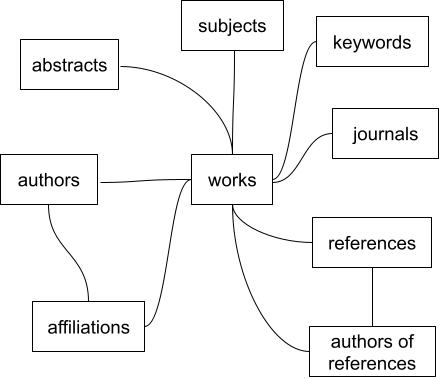

## Preparation

Steps to load Python modules and authentication.

- Check the project name in the follwing scripts.
- Check your access to Google Big Query using your google account.

If you are running this scripts inside the Google Colab Environment, the following snippets will provide access to your Google credentials in order to access Google Big Query. You should check if you have a Billing account to run the queries and that you have configured a project. By sure to access Big Query for the first time and follow instructions to check it. Also, change the project name in the cells for yours.

## Technical information

- If you have no experience in Google Big Query, read:
(https://cloud.google.com/bigquery/docs/introduction).

- The platform is accessible at
(https://cloud.google.com/bigquery).

- The public datasets created in the context of this project can be seen at (https://cloud.google.com/bigquery?project=insyspo).

- If you want to have an introduction on how Google Colab notebooks interact with Big Query, see:
(https://colab.research.google.com/notebooks/bigquery.ipynb).

- If you do not want to use the browser, it also possible to run queries in Big Query from you local computer.  To that effect, you should install and configure Google CLI (command-line-interface). The following instructions are made for that:

  - Google CLI
https://cloud.google.com/cli
  - Google Authentication
https://cloud.google.com/docs/authentication/provide-credentials-adc

In [ ]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


## Origin of data

### Scielo metadata as a dump

Compressed file with most of Scielo metadata provided by Scielo:

http://static.scielo.org/articlemeta/scielo_articles.zip

When uncompressed it producess a bulk of XML files. Each file is the metadata for a work. The XML can be read in Python as a dictionary and imported into a JSON string row in a table. Here the table is called `scielo_works`.

## Download the compressed file

## Correction of files

Some files are invalid because they use quote (') instead of double quote (") for field names and values.

In the following, we separated the files, use a regular expression to isolate only the positions surrounding field names and values and replace them. It is necessary to use a regular expression to avoid replacing apostrophes inside abstracts and titles.

### Preparation

Python modules and BigQuery accesss.

In [ ]:
import re
import copy
import pandas as pd
import os, glob
import numpy as np
import matplotlib.pyplot as plt

from google.cloud import bigquery
from google.cloud.bigquery.job import LoadJobConfig, WriteDisposition, CreateDisposition

In [ ]:
bq_client = bigquery.Client(project='insyspo')

In [ ]:
def save_to_bqtable(ts,Ti):

    table_id = 'insyspo.projectdb_scielo_rm.'+ts
    load_config = LoadJobConfig(create_disposition=CreateDisposition.CREATE_IF_NEEDED,
                               write_disposition=WriteDisposition.WRITE_TRUNCATE)

    job = bq_client.load_table_from_dataframe(
        dataframe=Ti, destination=table_id,job_config=load_config
    )
    job.result()



### Isolate files

In [ ]:
%%bigquery --project=insyspo

CREATE TABLE insyspo.projectdb_scielo_rm.json_invalid AS (
  WITH valids AS (
    SELECT work,
      IF(JSON_EXTRACT(work, '$') IS NULL, false, true) AS valid_json
    FROM `insyspo.publicdb_scielo.scielo_works`
  )
  SELECT work,
  FROM valids
  WHERE NOT valid_json
);


Query is running:   0%|          |

Downloading:   0%|          |

### Correct files in batches

If the full table of problematic files is large, it is loaded in batches using `LIMIT` and `OFFSET` statements. After that, the batch is corrected and saved to a table. The next three code cells should be run several times changing the batch until the table ends.

In [ ]:
%%bigquery to_correct --project=insyspo

SELECT work
FROM insyspo.projectdb_scielo_rm.json_invalid
LIMIT 10000
OFFSET 160000

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
to_re = list(to_correct['work'])
p = re.compile("'[^']+?':") # field name
p_ = re.compile(": '[^']+?'") # field value
p__ = re.compile(": \['[^\]]+?'\]") # array element field value

corrected = []

for s in to_re:

  sc = copy.deepcopy(s)

  # correct field names
  for m in p.finditer(s):
      si = m.start()
      pat = m.group()
      n = len(m.group())

      sc = sc[:si]+'"'+sc[si+1:si+n-2]+'"'+sc[si-1+n:]

  # correct field values
  for m in p_.finditer(sc):
      si = m.start()
      pat = m.group()
      n = len(m.group())

      sc = sc[:si+2]+'"'+sc[si+3:si+n-1]+'"'+sc[si+n:]

  # correct strings inside arrays
  for m in p__.finditer(sc):
      si = m.start()
      pat = m.group()
      n = len(m.group())
      pat = pat.replace("'",'"')

      sc = sc[:si]+pat+sc[si+n:]

  # correct 'None' fields without quotes
  sc = sc.replace(': None',': "None"')

  corrected += [sc]

corrected_df = pd.DataFrame({'work':corrected})

In [ ]:
save_to_bqtable('scielo_works_to_correct',corrected_df)

### Combine tables

Combine the correct portion of the original table with the of corrected elements.

In [ ]:
%%bigquery --project=insyspo

DROP TABLE IF EXISTS `insyspo.projectdb_scielo_rm.scielo_works_c`;
CREATE TABLE `insyspo.projectdb_scielo_rm.scielo_works_c` AS (
  WITH valids AS (
    SELECT work,
      IF(JSON_EXTRACT(work, '$') IS NULL, false, true) AS valid_json
    FROM `insyspo.publicdb_scielo.scielo_works`
  )
  SELECT work,
  FROM valids
  WHERE valid_json
  UNION ALL
  SELECT work
  FROM `insyspo.projectdb_scielo_rm.scielo_works_to_correct`
)

Query is running:   0%|          |

""


## Structural statistics

Count the number of fields in the SciELO database. It does not distinguish root fields from terminal fields.

The count is made useing the regular expression for a JSON field labels. Also. evaluates average number of fields.

In [ ]:
%%bigquery --project=insyspo

SELECT  SUM(ARRAY_LENGTH(REGEXP_EXTRACT_ALL(work, r"'([^\']+)':"))) AS all_fields,
  AVG(ARRAY_LENGTH(REGEXP_EXTRACT_ALL(work, r"'([^\']+)':"))) AS mean_fields
FROM `insyspo.projectdb_scielo_rm.scielo_works_c`

Query is running:   0%|          |

Downloading:   0%|          |

,all_fields,mean_fields
0,423599387,398.968658


# Diagram of tables

[Diagram](https://github.com/alyssonmazoni/scielo_relational_model/blob/50039762911ab9f45dc3e26a812c584e6221bbd9/SciELO%20model.png)

[Tables](https://github.com/alyssonmazoni/scielo_relational_model/blob/3b2337073eb2de3f47543eece8795f579978870a/SciELO%20journals.drawio%20(2).png)

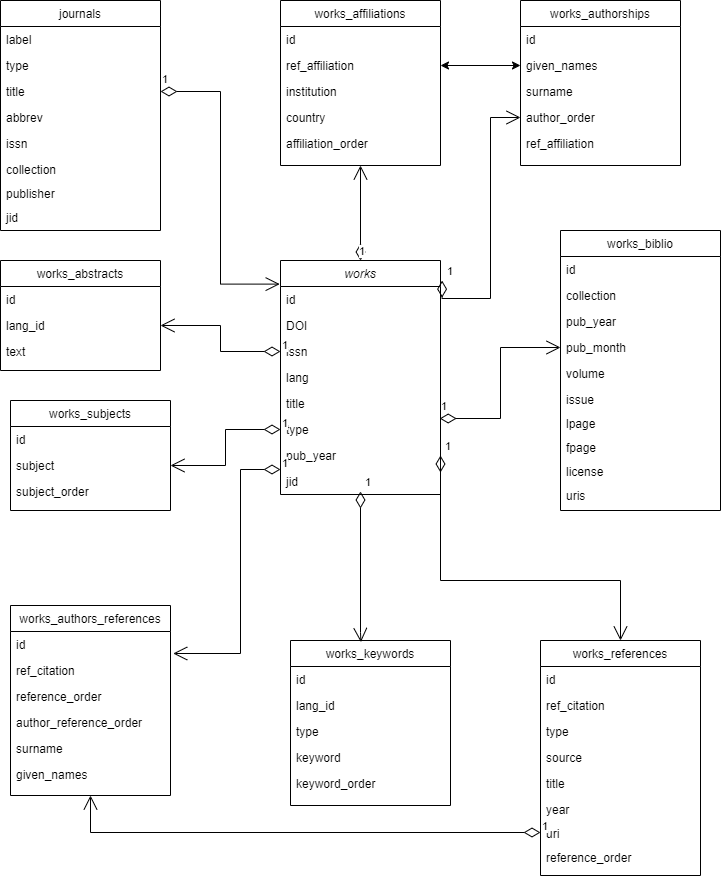

- Convert affiliations to affiliations and and institutions.
- Convert authors to authorships and authors.
- Plots for presence of tables.
- Tables of presence of metadata.
- Correct and disambiguate country.
- Table ORCID X Names of ORCIDs found in SciELO.


## Journals

In [ ]:
%%bigquery --project=insyspo

DROP TABLE IF EXISTS `insyspo.projectdb_scielo_rm.journals`;
CREATE TABLE `insyspo.projectdb_scielo_rm.journals` AS (
  WITH journals_aux AS (
  SELECT
        TRIM(JSON_EXTRACT(
          work,
          "$.articles.article.front.journal-meta.journal-id['#text']"),'"') AS journal_id,
        TRIM(JSON_EXTRACT(
          work,
          "$.articles.article.front.journal-meta.journal-id['@journal-id-type']"),'"') AS journal_type,
        TRIM(JSON_EXTRACT(
          work,
          "$.articles.article.front.journal-meta.journal-title-group.journal-title"),'"') AS journal_title,
        TRIM(JSON_EXTRACT(
          work,
          "$.articles.article.front.journal-meta.journal-title-group.abbrev-journal-title"),'"') AS abbrev_journal,
        TRIM(JSON_EXTRACT(
          work,
          "$.articles.article.front.journal-meta.issn"),'"') AS issn,
        TRIM(JSON_EXTRACT(
          work,
          "$.articles.article.front.journal-meta.collection"),'"') AS collection,
        TRIM(JSON_EXTRACT(
          work,
          "$.articles.article.front.journal-meta.publisher.publisher-name"),'"') AS publisher,
  FROM `insyspo.projectdb_scielo_rm.scielo_works_c`
  )
  SELECT
    ROW_NUMBER() OVER() AS jid,
    ANY_VALUE(journal_id) AS label,
    ANY_VALUE(journal_type) AS type,
    journal_title AS title,
    ANY_VALUE(abbrev_journal) AS abbrev,
    STRING_AGG(DISTINCT(issn), ', ') AS issn,
    ANY_VALUE(collection) AS collection,
    ANY_VALUE(publisher) AS publisher,
  FROM journals_aux
  GROUP BY title
);


ERROR:
 ("Failed to retrieve http://metadata.google.internal/computeMetadata/v1/instance/service-accounts/default/?recursive=true from the Google Compute Engine metadata service. Status: 404 Response:\nb''", <google.auth.transport.requests._Response object at 0x790171daf3d0>)


In [ ]:
%%bigquery --project=insyspo

SELECT column_name
FROM insyspo.projectdb_scielo_rm.INFORMATION_SCHEMA.COLUMNS
WHERE table_name LIKE 'journals'

Query is running:   0%|          |

Downloading:   0%|          |

,column_name
0,jid
1,label
2,type
3,title
4,abbrev
5,issn
6,collection
7,publisher


## Works

Table with information about works. The original dump contains repetitions because there is overlapping of works in the field `collection`.


In [ ]:
%%bigquery --project=insyspo

DROP TABLE IF EXISTS `insyspo.projectdb_scielo_rm.r_works`;
CREATE TABLE `insyspo.projectdb_scielo_rm.r_works` AS (
WITH repeated_works AS (
SELECT  TRIM(COALESCE(
          JSON_EXTRACT(
            work,
            "$.articles.article.front.article-meta.unique-article-id['#text']"),
          JSON_EXTRACT(
            work,
            "$.articles.article.front.article-meta.article-id[0]['#text']"),
          JSON_EXTRACT(
            work,
            "$.articles.article.front.article-meta.article-id['#text']")
        ),'"') AS id,
        TRIM(JSON_EXTRACT(
          work,
          "$.articles.article.front.article-meta.article-id[1]['#text']"),'"') AS doi,
        TRIM(COALESCE(
          JSON_EXTRACT(
            work,
            "$.articles.article.front.article-meta.title-group.article-title['#text']"),
          JSON_EXTRACT(
            work,
            "$.articles.article.front.article-meta.title-group.article-title[0]['#text']")
        ),'"') AS title,
        TRIM(JSON_EXTRACT(
          work,
          "$.articles.article['@lang_id']"),'"') AS lang,
        TRIM(JSON_EXTRACT(
          work,
          "$.articles.article['@article-type']"),'"') AS type,
        TRIM(JSON_EXTRACT(
          work,
          "$.articles.article.front.journal-meta.issn"),'"') AS issn,
        COALESCE(
          CAST(TRIM(JSON_EXTRACT(
            work,
            "$.articles.article.front.article-meta['date']['year']"),'"') AS INT),
          CAST(TRIM(JSON_EXTRACT(
            work,
            "$.articles.article.front.article-meta['pub-date']['year']"),'"') AS INT)) AS pub_year,
FROM `insyspo.projectdb_scielo_rm.scielo_works_c`
GROUP BY id, doi, title, lang, type, issn, pub_year
)
SELECT *
FROM repeated_works
WHERE id IS NOT NULL
);

DROP TABLE IF EXISTS `insyspo.projectdb_scielo_rm.works`;
CREATE TABLE `insyspo.projectdb_scielo_rm.works` AS (
WITH aux AS (
  SELECT id,
    doi,
    issn,
    title,
    lang,
    type,
    pub_year,
    ROW_NUMBER() OVER (PARTITION BY id ORDER BY id DESC) r,
  FROM `insyspo.projectdb_scielo_rm.r_works`
  ORDER BY id
  )
  SELECT a.id,
      a.doi,
      a.issn,
      a.title,
      a.lang,
      a.type,
      a.pub_year,
      b.jid
  FROM aux AS a
  JOIN insyspo.projectdb_scielo_rm.journals AS b
  ON a.issn LIKE CONCAT('%',b.issn,'%')
  WHERE r = 1 AND id IS NOT NULL
  ORDER BY r DESC, id
);

DROP TABLE IF EXISTS `insyspo.projectdb_scielo_rm.r_works`;

Query is running:   0%|          |

""


In [ ]:
%%bigquery --project=insyspo

SELECT column_name
FROM insyspo.projectdb_scielo_rm.INFORMATION_SCHEMA.COLUMNS
WHERE table_name LIKE 'works'

Query is running:   0%|          |

Downloading:   0%|          |

,column_name
0,id
1,doi
2,issn
3,title
4,lang
5,type
6,pub_year
7,jid


In [ ]:
%%bigquery --project=insyspo

SELECT COUNT(*) AS n, COUNT(DISTINCT(id)) AS nid
FROM `insyspo.projectdb_scielo_rm.works`;

Query is running:   0%|          |

Downloading:   0%|          |

,n,nid
0,977117,977117


## Bibliographic

In [ ]:
%%bigquery --project=insyspo

DROP TABLE IF EXISTS `insyspo.projectdb_scielo_rm.works_biblio`;
CREATE TABLE `insyspo.projectdb_scielo_rm.works_biblio` AS (
WITH works AS (
SELECT  TRIM(COALESCE(
          JSON_EXTRACT(
            work,
            "$.articles.article.front.article-meta.unique-article-id['#text']"),
          JSON_EXTRACT(
            work,
            "$.articles.article.front.article-meta.article-id[0]['#text']"),
          JSON_EXTRACT(
            work,
            "$.articles.article.front.article-meta.article-id['#text']")
        ),'"') AS id,
        TRIM(JSON_EXTRACT(
          work,
          '$.articles.article.front.journal-meta.collection'),'"') AS collection,
        COALESCE(
          CAST(TRIM(JSON_EXTRACT(
            work,
            "$.articles.article.front.article-meta['pub-date']['year']"),'"') AS INT),
          CAST(TRIM(JSON_EXTRACT(
            work,
            "$.articles.article.front.article-meta['date']['year']"),'"') AS INT))
             AS pub_year,
        COALESCE(
          CAST(TRIM(JSON_EXTRACT(
            work,
            "$.articles.article.front.article-meta['pub-date']['month']"),'"') AS INT),
          CAST(TRIM(JSON_EXTRACT(
            work,
            "$.articles.article.front.article-meta['date']['month']"),'"') AS INT))
             AS pub_month,
        TRIM(JSON_EXTRACT(
          work,
          '$.articles.article.front.article-meta.volume'),'"') AS volume,
        TRIM(JSON_EXTRACT(
          work,
          '$.articles.article.front.article-meta.issue'),'"') AS issue,
        TRIM(JSON_EXTRACT(
          work,
          '$.articles.article.front.article-meta.lpage'),'"') AS lpage,
        TRIM(JSON_EXTRACT(
          work,
          '$.articles.article.front.article-meta.fpage'),'"') AS fpage,
        TRIM(JSON_EXTRACT(
          work,
          "$.articles.article.front.article-meta.permissions.license['@license-type']"),'"') AS license,
        TRIM(JSON_EXTRACT(
          work,
          "$.articles.article.front.article-meta.self-uri"),'"') AS uris,
FROM `insyspo.projectdb_scielo_rm.scielo_works_c`
)
SELECT DISTINCT *
FROM works
WHERE id IS NOT NULL
);

Query is running:   0%|          |

""


In [ ]:
%%bigquery --project=insyspo

SELECT column_name
FROM insyspo.projectdb_scielo_rm.INFORMATION_SCHEMA.COLUMNS
WHERE table_name LIKE 'works_biblio'

Query is running:   0%|          |

Downloading:   0%|          |

,column_name
0,id
1,collection
2,pub_year
3,pub_month
4,volume
5,issue
6,lpage
7,fpage
8,license
9,uris


## Abstracts

In [ ]:
%%bigquery --project=insyspo

DROP TABLE IF EXISTS `insyspo.projectdb_scielo_rm.works_abstracts`;
CREATE TABLE `insyspo.projectdb_scielo_rm.works_abstracts` AS (
SELECT DISTINCT TRIM(COALESCE(
          JSON_EXTRACT(
            work,
            "$.articles.article.front.article-meta.unique-article-id['#text']"),
          JSON_EXTRACT(
            work,
            "$.articles.article.front.article-meta.article-id[0]['#text']"),
          JSON_EXTRACT(
            work,
            "$.articles.article.front.article-meta.article-id['#text']")
        ),'"') AS id,
        TRIM(JSON_EXTRACT(
          work,
          "$.articles.article.front.article-meta.abstract['@lang_id']"),'"') AS lang_id,
        TRIM(JSON_EXTRACT(
          work,
          "$.articles.article.front.article-meta.abstract.p"),'"') AS text,
FROM `insyspo.projectdb_scielo_rm.scielo_works_c`
WHERE JSON_EXTRACT(
          work,
          "$.articles.article.front.article-meta.abstract.p") IS NOT NULL
);


Query is running:   0%|          |

""


In [ ]:
%%bigquery --project=insyspo

SELECT column_name
FROM insyspo.projectdb_scielo_rm.INFORMATION_SCHEMA.COLUMNS
WHERE table_name LIKE 'works_abstracts'

Query is running:   0%|          |

Downloading:   0%|          |

,column_name
0,id
1,lang_id
2,text


## Subjects

In [ ]:
%%bigquery --project=insyspo

DROP TABLE IF EXISTS insyspo.projectdb_scielo_rm.works_subjects;
CREATE TABLE insyspo.projectdb_scielo_rm.works_subjects AS (
  WITH subjects AS (
    SELECT TRIM(COALESCE(
          JSON_EXTRACT(
            work,
            "$.articles.article.front.article-meta.unique-article-id['#text']"),
          JSON_EXTRACT(
            work,
            "$.articles.article.front.article-meta.article-id[0]['#text']"),
          JSON_EXTRACT(
            work,
            "$.articles.article.front.article-meta.article-id['#text']")
        ),'"') AS id,
            JSON_EXTRACT_ARRAY(
              work,
              "$.articles.article.front.article-meta.article-categories.subj-group.subject") AS subjs,
     FROM `insyspo.projectdb_scielo_rm.scielo_works_c`
     WHERE JSON_EXTRACT_ARRAY(
              work,
              "$.articles.article.front.article-meta.article-categories.subj-group.subject") IS NOT NULL
  )
  SELECT id,
    TRIM(s,'"') AS subject,
    off+1 AS subject_order
  FROM subjects, UNNEST(subjs) AS s WITH OFFSET AS off
  WHERE id IS NOT NULL AND subjs IS NOT NULL
  UNION ALL
      SELECT TRIM(COALESCE(
          JSON_EXTRACT(
            work,
            "$.articles.article.front.article-meta.unique-article-id['#text']"),
          JSON_EXTRACT(
            work,
            "$.articles.article.front.article-meta.article-id[0]['#text']"),
          JSON_EXTRACT(
            work,
            "$.articles.article.front.article-meta.article-id['#text']")
        ),'"') AS id,
        TRIM(JSON_EXTRACT(
              work,
              "$.articles.article.front.article-meta.article-categories.subj-group.subject"),'"') AS subject,
        1 AS subject_order
     FROM `insyspo.projectdb_scielo_rm.scielo_works_c`
     WHERE JSON_EXTRACT_ARRAY(
              work,
              "$.articles.article.front.article-meta.article-categories.subj-group.subject") IS NULL
)

Query is running:   0%|          |

""


In [ ]:
%%bigquery --project=insyspo

SELECT column_name
FROM insyspo.projectdb_scielo_rm.INFORMATION_SCHEMA.COLUMNS
WHERE table_name LIKE 'works_subjects'

Query is running:   0%|          |

Downloading:   0%|          |

,column_name
0,id
1,subject
2,subject_order


## Authors

In [ ]:
%%bigquery --project=insyspo

DROP TABLE IF EXISTS `insyspo.projectdb_scielo_rm.works_authors`;
CREATE TABLE `insyspo.projectdb_scielo_rm.works_authors` AS (
  WITH authors_fjs AS (
    SELECT TRIM(COALESCE(
          JSON_EXTRACT(
            work,
            "$.articles.article.front.article-meta.unique-article-id['#text']"),
          JSON_EXTRACT(
            work,
            "$.articles.article.front.article-meta.article-id[0]['#text']"),
          JSON_EXTRACT(
            work,
            "$.articles.article.front.article-meta.article-id['#text']")
        ),'"') AS id,
          JSON_EXTRACT_ARRAY(
            work,
            "$.articles.article.front.article-meta.contrib-group.contrib") AS authors
    FROM `insyspo.projectdb_scielo_rm.scielo_works_c`
    WHERE JSON_EXTRACT_ARRAY(
            work,
            "$.articles.article.front.article-meta.contrib-group.contrib") IS NOT NULL
  )
  SELECT DISTINCT TRIM(id,'"') AS id,
    TRIM(JSON_EXTRACT(author,"$.name.surname"),'"') AS surname,
    TRIM(JSON_EXTRACT(author,"$.name.given-names"),'"') AS given_names,
    TRIM(JSON_EXTRACT(author,"$.xref['@rid']"),'"') AS ref_affiliation,
    off+1 AS author_order
  FROM authors_fjs,
  UNNEST(authors) author WITH OFFSET AS off
  UNION ALL
      SELECT TRIM(COALESCE(
          JSON_EXTRACT(
            work,
            "$.articles.article.front.article-meta.unique-article-id['#text']"),
          JSON_EXTRACT(
            work,
            "$.articles.article.front.article-meta.article-id[0]['#text']"),
          JSON_EXTRACT(
            work,
            "$.articles.article.front.article-meta.article-id['#text']")
        ),'"') AS id,
          TRIM(JSON_EXTRACT(
            work,
            "$.articles.article.front.article-meta.contrib-group.contrib.name.surname"),'"') AS surname,
          TRIM(JSON_EXTRACT(
            work,
            "$.articles.article.front.article-meta.contrib-group.contrib.name.given-names"),'"') AS given_names,
          TRIM(JSON_EXTRACT(
            work,
            "$.articles.article.front.article-meta.contrib-group.contrib.xref['@rid']"),'"') AS ref_affiliation,
            1 AS author_order
    FROM `insyspo.projectdb_scielo_rm.scielo_works_c`
    WHERE JSON_EXTRACT_ARRAY(
            work,
            "$.articles.article.front.article-meta.contrib-group.contrib") IS NULL
);


Query is running:   0%|          |

""


In [ ]:
%%bigquery --project=insyspo

SELECT column_name
FROM insyspo.projectdb_scielo_rm.INFORMATION_SCHEMA.COLUMNS
WHERE table_name LIKE 'works_authors'

Query is running:   0%|          |

Downloading:   0%|          |

,column_name
0,id
1,surname
2,given_names
3,ref_affiliation
4,author_order


## Affiliations



In [ ]:
%%bigquery --project=insyspo

DROP TABLE IF EXISTS `insyspo.projectdb_scielo_rm.works_affiliations`;
CREATE TABLE `insyspo.projectdb_scielo_rm.works_affiliations` AS (
  WITH affiliations_fjs AS (
    SELECT TRIM(COALESCE(
          JSON_EXTRACT(
            work,
            "$.articles.article.front.article-meta.unique-article-id['#text']"),
          JSON_EXTRACT(
            work,
            "$.articles.article.front.article-meta.article-id[0]['#text']"),
          JSON_EXTRACT(
            work,
            "$.articles.article.front.article-meta.article-id['#text']")
        ),'"') AS id,
          JSON_EXTRACT_ARRAY(
            work,
            '$.articles.article.front.article-meta.aff') AS affiliations
    FROM `insyspo.projectdb_scielo_rm.scielo_works_c`
    WHERE JSON_EXTRACT_ARRAY(
            work,
            '$.articles.article.front.article-meta.aff') IS NOT NULL
  )
  SELECT DISTINCT TRIM(id,'"') AS id,
    TRIM(JSON_EXTRACT(affiliation,"$['@id']"),'"') AS ref_affiliation,
    TRIM(JSON_EXTRACT(affiliation,"$.institution"),'"') AS institution,
    TRIM(JSON_EXTRACT(affiliation,"$.country"),'"') AS country,
    off+1 AS affiliation_order
  FROM affiliations_fjs,
  UNNEST(affiliations) affiliation WITH offset AS off
  WHERE TRIM(JSON_EXTRACT(affiliation,"$.institution"),'"') IS NOT NULL
      AND TRIM(JSON_EXTRACT(affiliation,"$.institution"),'"') != 'None'
  UNION ALL
  SELECT TRIM(COALESCE(
          JSON_EXTRACT(
            work,
            "$.articles.article.front.article-meta.unique-article-id['#text']"),
          JSON_EXTRACT(
            work,
            "$.articles.article.front.article-meta.article-id[0]['#text']"),
          JSON_EXTRACT(
            work,
            "$.articles.article.front.article-meta.article-id['#text']")
        ),'"') AS id,
        TRIM(JSON_EXTRACT(
            work,
            "$.articles.article.front.article-meta.aff['@id']"),'"') AS ref_affiliation,
        TRIM( JSON_EXTRACT(
            work,
            "$.articles.article.front.article-meta.aff.institution"),'"') AS institution,
        TRIM(JSON_EXTRACT(
            work,
            "$.articles.article.front.article-meta.aff.country"),'"') AS country,
          1 AS affiliation_order
  FROM `insyspo.projectdb_scielo_rm.scielo_works_c`
  WHERE JSON_EXTRACT_ARRAY(
            work,
            '$.articles.article.front.article-meta.aff') IS NULL AND
        JSON_EXTRACT(
            work,
            "$.articles.article.front.article-meta.aff.institution") IS NOT NULL
            AND
        TRIM(JSON_EXTRACT(
            work,
            "$.articles.article.front.article-meta.aff.institution"),'"') != 'None'
);

Query is running:   0%|          |

""


In [ ]:
%%bigquery --project=insyspo

SELECT column_name
FROM insyspo.projectdb_scielo_rm.INFORMATION_SCHEMA.COLUMNS
WHERE table_name LIKE 'works_affiliations'

Query is running:   0%|          |

Downloading:   0%|          |

,column_name
0,id
1,ref_affiliation
2,institution
3,country
4,affiliation_order


## References

Works referenced. They are usually not part of Scielo.

In [ ]:
%%bigquery --project=insyspo

DROP TABLE IF EXISTS `insyspo.projectdb_scielo_rm.works_references`;
CREATE TABLE `insyspo.projectdb_scielo_rm.works_references` AS (
  WITH references_fjs AS (
    SELECT TRIM(COALESCE(
          JSON_EXTRACT(
            work,
            "$.articles.article.front.article-meta.unique-article-id['#text']"),
          JSON_EXTRACT(
            work,
            "$.articles.article.front.article-meta.article-id[0]['#text']"),
          JSON_EXTRACT(
            work,
            "$.articles.article.front.article-meta.article-id['#text']")
        ),'"') AS id,
        JSON_EXTRACT_ARRAY(
          work,
          "$.articles.article.back.ref-list.ref") AS references
    FROM `insyspo.projectdb_scielo_rm.scielo_works_c`
    WHERE JSON_EXTRACT_ARRAY(
          work,
          "$.articles.article.back.ref-list.ref") IS NOT NULL
  )
  SELECT DISTINCT TRIM(id,'"') AS id,
    TRIM(JSON_EXTRACT(reference,"$['@id']"),'"') AS ref_citation,
    TRIM(JSON_EXTRACT(reference,"$.element-citation['@publication-type']"),'"') AS type,
    TRIM(JSON_EXTRACT(reference,"$.element-citation.source"),'"') AS source,
    TRIM(JSON_EXTRACT(reference,"$.element-citation.article-title"),'"') AS title,
    TRIM(JSON_EXTRACT(reference,"$.element-citation.date.year"),'"') AS year,
    #TRIM(JSON_EXTRACT(reference,'$.element-citation.person-group'),'"') AS authors,
    #TRIM(JSON_EXTRACT(reference,"$.element-citation.ext-link"),'"') AS ext_link,
    TRIM(JSON_EXTRACT(reference,"$.element-citation.ext-link['@href']"),'"') AS uri,
    off+1 AS reference_order
  FROM references_fjs,
  UNNEST(references) reference WITH OFFSET AS off
  UNION ALL
  SELECT TRIM(COALESCE(
          JSON_EXTRACT(
            work,
            "$.articles.article.front.article-meta.unique-article-id['#text']"),
          JSON_EXTRACT(
            work,
            "$.articles.article.front.article-meta.article-id[0]['#text']"),
          JSON_EXTRACT(
            work,
            "$.articles.article.front.article-meta.article-id['#text']")
        ),'"') AS id,
        TRIM(JSON_EXTRACT(
          work,
          "$.articles.article.back.ref-list.ref['@id']"),'"') AS ref_citation,
        TRIM(JSON_EXTRACT(
          work,
          "$.articles.article.back.ref-list.ref.element-citation['@publication-type']"),'"') AS type,
        TRIM(JSON_EXTRACT(
          work,
          "$.articles.article.back.ref-list.ref.element-citation.source"),'"') AS source,
        TRIM(JSON_EXTRACT(
          work,
          "$.articles.article.back.ref-list.ref.element-citation.article-title"),'"') AS title,
        TRIM(JSON_EXTRACT(
          work,
          "$.articles.article.back.ref-list.ref.element-citation.date.year"),'"') AS year,
        TRIM(JSON_EXTRACT(
          work,
          "$.articles.article.back.ref-list.ref.element-citation.ext-link['@href']"),'"') AS uri,
        1 AS reference_order,
    FROM `insyspo.projectdb_scielo_rm.scielo_works_c`
    WHERE JSON_EXTRACT_ARRAY(
          work,
          "$.articles.article.back.ref-list.ref") IS NULL
);

Query is running:   0%|          |

""


In [ ]:
%%bigquery --project=insyspo

SELECT column_name
FROM insyspo.projectdb_scielo_rm.INFORMATION_SCHEMA.COLUMNS
WHERE table_name LIKE 'works_references'

Query is running:   0%|          |

Downloading:   0%|          |

,column_name
0,id
1,ref_citation
2,type
3,source
4,title
5,year
6,uri
7,reference_order


## Authors of references

In [ ]:
%%bigquery --project=insyspo

DROP TABLE IF EXISTS `insyspo.projectdb_scielo_rm.authors_references`;
CREATE TABLE `insyspo.projectdb_scielo_rm.authors_references` AS (
    WITH references_fjs AS (
      SELECT TRIM(COALESCE(
          JSON_EXTRACT(
            work,
            "$.articles.article.front.article-meta.unique-article-id['#text']"),
          JSON_EXTRACT(
            work,
            "$.articles.article.front.article-meta.article-id[0]['#text']"),
          JSON_EXTRACT(
            work,
            "$.articles.article.front.article-meta.article-id['#text']")
        ),'"') AS id,
            JSON_EXTRACT_ARRAY(
              work,
              "$.articles.article.back.ref-list.ref") AS references
      FROM `insyspo.projectdb_scielo_rm.scielo_works_c`
      WHERE JSON_EXTRACT_ARRAY(
              work,
              "$.articles.article.back.ref-list.ref") IS NOT NULL
    )
    SELECT id,
      TRIM(JSON_EXTRACT(reference,"$['@id']"),'"') AS ref_citation,
      JSON_EXTRACT(reference,"$.element-citation.person-group.name") AS authors,
      off+1 AS reference_order
    FROM references_fjs,
    UNNEST(references) reference WITH OFFSET AS off
    UNION ALL
    SELECT TRIM(COALESCE(
          JSON_EXTRACT(
            work,
            "$.articles.article.front.article-meta.unique-article-id['#text']"),
          JSON_EXTRACT(
            work,
            "$.articles.article.front.article-meta.article-id[0]['#text']"),
          JSON_EXTRACT(
            work,
            "$.articles.article.front.article-meta.article-id['#text']")
        ),'"') AS id,
        TRIM(JSON_EXTRACT(
              work,
              "$.articles.article.back.ref-list.ref['@id']"),'"') AS ref_citation,
        JSON_EXTRACT(
              work,
              "$.articles.article.back.ref-list.ref.element-citation.person-group.name") AS authors,
        1 AS reference_order,
    FROM `insyspo.projectdb_scielo_rm.scielo_works_c`
    WHERE JSON_EXTRACT_ARRAY(
              work,
              "$.articles.article.back.ref-list.ref") IS NULL
);

DROP TABLE IF EXISTS `insyspo.projectdb_scielo_rm.works_authors_references`;
CREATE TABLE `insyspo.projectdb_scielo_rm.works_authors_references` AS (
  WITH aux AS (
    SELECT id,
      ref_citation,
      reference_order,
      JSON_EXTRACT_ARRAY(authors, "$") AS authors_a
    FROM `insyspo.projectdb_scielo_rm.authors_references`
    WHERE JSON_EXTRACT_ARRAY(authors, "$") IS NOT NULL
  )
  SELECT id,
    ref_citation,
    reference_order,
    TRIM(JSON_EXTRACT(author,"$.surname"),'"') AS surname,
    TRIM(JSON_EXTRACT(author,"$.given-names"),'"') AS given_names,
    off+1 AS author_reference_order
  FROM aux,
  UNNEST(authors_a) author WITH OFFSET AS off
  WHERE author IS NOT NULL
    AND TRIM(JSON_EXTRACT(author,"$.surname"),'"') IS NOT NULL
  UNION ALL
  SELECT id,
    ref_citation,
    reference_order,
    TRIM(JSON_EXTRACT(authors,"$.surname"),'"') AS surname,
    TRIM(JSON_EXTRACT(authors,"$.given-names"),'"') AS given_names,
    1 AS author_reference_order
  FROM `insyspo.projectdb_scielo_rm.authors_references`
  WHERE JSON_EXTRACT_ARRAY(authors, "$") IS NULL
    AND authors IS NOT NULL
    AND TRIM(JSON_EXTRACT(authors,"$.surname"),'"') IS NOT NULL

);

DROP TABLE IF EXISTS `insyspo.projectdb_scielo_rm.authors_references`;

Query is running:   0%|          |

""


In [ ]:
%%bigquery --project=insyspo

SELECT column_name
FROM insyspo.projectdb_scielo_rm.INFORMATION_SCHEMA.COLUMNS
WHERE table_name LIKE 'works_authors_references'

Query is running:   0%|          |

Downloading:   0%|          |

,column_name
0,id
1,ref_citation
2,reference_order
3,surname
4,given_names
5,author_reference_order


## Keywords

In [ ]:
%%bigquery --project=insyspo

DROP TABLE IF EXISTS `insyspo.projectdb_scielo_rm.keywords`;
CREATE TABLE `insyspo.projectdb_scielo_rm.keywords` AS (
  WITH kwd_groups AS (
    SELECT TRIM(COALESCE(
          JSON_EXTRACT(
            work,
            "$.articles.article.front.article-meta.unique-article-id['#text']"),
          JSON_EXTRACT(
            work,
            "$.articles.article.front.article-meta.article-id[0]['#text']"),
          JSON_EXTRACT(
            work,
            "$.articles.article.front.article-meta.article-id['#text']")
        ),'"') AS id,
      JSON_EXTRACT_ARRAY(
        work,
        "$.articles.article.front.article-meta.kwd-group") AS keywords
    FROM `insyspo.projectdb_scielo_rm.scielo_works_c`
    WHERE JSON_EXTRACT_ARRAY(
        work,
        "$.articles.article.front.article-meta.kwd-group") IS NOT NULL
  )
  SELECT id,
    TRIM(JSON_EXTRACT(kwds,"$['@lang_id']"),'"') AS lang_id,
    TRIM(JSON_EXTRACT(kwds,"$['@kwd-group-type']"),'"') AS type,
    JSON_EXTRACT(kwds,"$.kwd") AS keywords
  FROM kwd_groups,
  UNNEST(keywords) kwds
  WHERE JSON_EXTRACT(kwds,"$.kwd") IS NOT NULL
  UNION ALL
  SELECT TRIM(COALESCE(
          JSON_EXTRACT(
            work,
            "$.articles.article.front.article-meta.unique-article-id['#text']"),
          JSON_EXTRACT(
            work,
            "$.articles.article.front.article-meta.article-id[0]['#text']"),
          JSON_EXTRACT(
            work,
            "$.articles.article.front.article-meta.article-id['#text']")
        ),'"') AS id,
      TRIM(JSON_EXTRACT(
        work,
        "$.articles.article.front.article-meta.kwd-group['@lang_id']"),'"') AS lang_id,
      TRIM(JSON_EXTRACT(
        work,
        "$.articles.article.front.article-meta.kwd-group['@kwd-group-type']"),'"') AS type,
      JSON_EXTRACT(
        work,
        "$.articles.article.front.article-meta.kwd-group.kwd") AS keywords,
  FROM `insyspo.projectdb_scielo_rm.scielo_works_c`
  WHERE JSON_EXTRACT_ARRAY(
        work,
        "$.articles.article.front.article-meta.kwd-group") IS NULL
        AND JSON_EXTRACT(
        work,
        "$.articles.article.front.article-meta.kwd-group.kwd") IS NOT NULL
);


DROP TABLE IF EXISTS `insyspo.projectdb_scielo_rm.works_keywords`;
CREATE TABLE `insyspo.projectdb_scielo_rm.works_keywords` AS (
  WITH aux AS (
    SELECT id,
      lang_id,
      type,
      JSON_EXTRACT_ARRAY(keywords,"$") AS keywords_a,
    FROM `insyspo.projectdb_scielo_rm.keywords`
    WHERE JSON_EXTRACT_ARRAY(keywords,"$") IS NOT NULL
  )
  SELECT id,
    lang_id,
    type,
    TRIM(keyword,'"') AS keyword,
    off+1 AS keyword_order
  FROM aux,
  UNNEST(keywords_a) keyword WITH OFFSET as off
  WHERE keyword IS NOT NULL
  UNION ALL
  SELECT id,
    lang_id,
    type,
    TRIM(keywords,'"') AS keyword,
    1 AS keyword_order
  FROM `insyspo.projectdb_scielo_rm.keywords`
  WHERE JSON_EXTRACT_ARRAY(keywords,"$") IS NULL
    AND TRIM(keywords,'"') IS NOT NULL
);

DROP TABLE IF EXISTS `insyspo.projectdb_scielo_rm.keywords`;

Query is running:   0%|          |

""


In [ ]:
%%bigquery --project=insyspo

SELECT column_name
FROM insyspo.projectdb_scielo_rm.INFORMATION_SCHEMA.COLUMNS
WHERE table_name LIKE 'works_keywords'

Query is running:   0%|          |

Downloading:   0%|          |

,column_name
0,id
1,lang_id
2,type
3,keyword
4,keyword_order


## Tables

In [ ]:
%%bigquery --project=insyspo

SELECT table_name
FROM insyspo.projectdb_scielo_rm.INFORMATION_SCHEMA.TABLES

Query is running:   0%|          |

Downloading:   0%|          |

,table_name
0,works_keywords
1,works
2,works_authors
3,match_scielo_oa
4,works_subjects
5,works_references
6,scielo_works_c
7,journals
8,json_invalid
9,works_authors_references


# Export to reference database

In [ ]:
%%bigquery --project=insyspo

DROP TABLE IF EXISTS insyspo.publicdb_scielo_relational_model.works;
CREATE TABLE insyspo.publicdb_scielo_relational_model.works
COPY insyspo.projectdb_scielo_rm.works;

DROP TABLE IF EXISTS insyspo.publicdb_scielo_relational_model.works_abstracts;
CREATE TABLE insyspo.publicdb_scielo_relational_model.works_abstracts
COPY insyspo.projectdb_scielo_rm.works_abstracts;

DROP TABLE IF EXISTS insyspo.publicdb_scielo_relational_model.works_biblio;
CREATE TABLE insyspo.publicdb_scielo_relational_model.works_biblio
COPY insyspo.projectdb_scielo_rm.works_biblio;

DROP TABLE IF EXISTS insyspo.publicdb_scielo_relational_model.journals;
CREATE TABLE insyspo.publicdb_scielo_relational_model.journals
COPY insyspo.projectdb_scielo_rm.journals;

DROP TABLE IF EXISTS insyspo.publicdb_scielo_relational_model.works_subjects;
CREATE TABLE insyspo.publicdb_scielo_relational_model.works_subjects
COPY insyspo.projectdb_scielo_rm.works_subjects;

DROP TABLE IF EXISTS insyspo.publicdb_scielo_relational_model.works_authors;
CREATE TABLE insyspo.publicdb_scielo_relational_model.works_authors
COPY insyspo.projectdb_scielo_rm.works_authors;

DROP TABLE IF EXISTS insyspo.publicdb_scielo_relational_model.works_references;
CREATE TABLE insyspo.publicdb_scielo_relational_model.works_references
COPY insyspo.projectdb_scielo_rm.works_references;

DROP TABLE IF EXISTS insyspo.publicdb_scielo_relational_model.works_keywords;
CREATE TABLE insyspo.publicdb_scielo_relational_model.works_keywords
COPY insyspo.projectdb_scielo_rm.works_keywords;

DROP TABLE IF EXISTS insyspo.publicdb_scielo_relational_model.works_authors_references;
CREATE TABLE insyspo.publicdb_scielo_relational_model.works_authors_references
COPY insyspo.projectdb_scielo_rm.works_authors_references;

DROP TABLE IF EXISTS insyspo.publicdb_scielo_relational_model.works_affiliations;
CREATE TABLE insyspo.publicdb_scielo_relational_model.works_affiliations
COPY insyspo.projectdb_scielo_rm.works_affiliations;


Query is running:   0%|          |

""


# Tables and plots

## Works

In [ ]:
%%bigquery works_meta --project=insyspo

SELECT
  COUNT(*) AS total,
  COUNT(doi) AS dois,
  COUNT(title) AS titles,
  COUNT(lang) AS langs,
  COUNT(type) AS types,
  COUNT(journal_id) AS journals,
  COUNT(pub_year) AS years
FROM insyspo.projectdb_scielo_rm.works

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
works_meta

,total,dois,titles,langs,types,journals,years
0,977117,668020,965497,977117,977117,977117,974723


<Axes: >

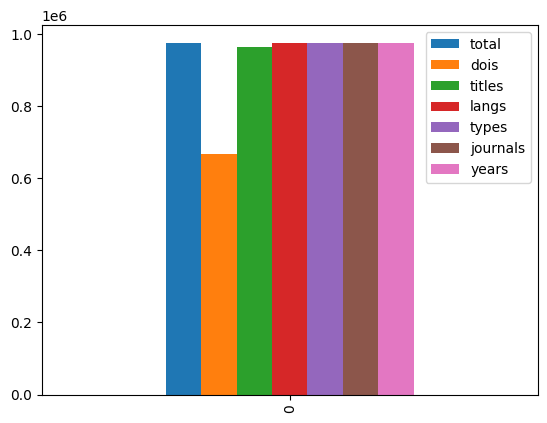

In [ ]:
works_meta.plot.bar()

In [ ]:
%%bigquery works_meta_type --project=insyspo

SELECT
  type,
  COUNT(*) AS total,
  COUNT(doi) AS dois,
  COUNT(title) AS titles,
  COUNT(lang) AS langs,
  COUNT(journal_id) AS journals,
  COUNT(pub_year) AS pub_years
FROM insyspo.projectdb_scielo_rm.works
GROUP BY type
ORDER BY total DESC

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
works_meta_type

In [ ]:
%%bigquery works_meta_year --project=insyspo

SELECT
  pub_year AS year,
  COUNT(*) AS total,
  COUNT(doi) AS dois,
  COUNT(title) AS titles,
  COUNT(lang) AS langs,
  COUNT(journal_id) AS journals,
  COUNT(type) AS types
FROM insyspo.projectdb_scielo_rm.works
GROUP BY pub_year
ORDER BY pub_year DESC

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
works_meta_year

In [ ]:
%%bigquery works_meta_collection --project=insyspo

SELECT
  b.collection,
  COUNT(a) AS total,
  COUNT(a.doi) AS dois,
  COUNT(a.title) AS titles,
  COUNT(a.lang) AS langs,
  COUNT(a.journal_id) AS journals,
  COUNT(a.pub_year) AS pub_years,
  COUNT(a.type) AS types
FROM insyspo.projectdb_scielo_rm.works AS a
JOIN insyspo.projectdb_scielo_rm.works_biblio AS b
ON a.id = b.id
GROUP BY b.collection
ORDER BY total DESC

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
works_meta_collection

,collection,total,dois,titles,langs,journals,pub_years,types
0,SciELO Brazil,458345,451158,455070,458345,458345,457503,458345
1,SciELO Colombia,88443,41899,87480,88443,88443,88109,88443
2,SciELO Mexico,82784,28777,82100,82784,82784,82605,82784
3,SciELO Chile,76752,60409,75866,76752,76752,76526,76752
4,SciELO Public Health,48734,41713,48074,48734,48734,48676,48734
5,SciELO Argentina,48368,6651,47177,48368,48368,48147,48368
6,SciELO Spain,44905,19579,43755,44905,44905,44834,44905
7,SciELO Cuba,42442,303,42230,42442,42442,42323,42442
8,SciELO South Africa,34877,20040,34293,34877,34877,34654,34877
9,SciELO Portugal,25158,10269,24564,25158,25158,25140,25158


## Bibliographic data

In [ ]:
%%bigquery biblio_meta_collection --project=insyspo

SELECT
  collection,
  COUNT(*) AS total,
  COUNT(pub_year) AS pub_years,
  COUNT(pub_month) AS pub_months,
  COUNT(volume) AS volumes,
  COUNT(issue) AS issues,
  COUNT(fpage) AS fpages,
  COUNT(lpage) AS lpages,
  COUNT(uris) AS uris
FROM insyspo.projectdb_scielo_rm.works_biblio
GROUP BY collection
ORDER BY total DESC

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
biblio_meta_collection

,collection,total,pub_years,pub_months,volumes,issues,fpages,lpages,uris
0,SciELO Brazil,458345,457494,347996,443118,418171,387421,387370,457494
1,SciELO Colombia,88443,88109,87965,72831,87851,85863,85857,88109
2,SciELO Mexico,82784,82604,64116,72143,79673,77298,77308,82604
3,SciELO Chile,76752,76526,57445,64948,74282,74866,74869,76526
4,SciELO Public Health,48734,48679,38275,48672,46170,42086,42085,48679
5,SciELO Argentina,48368,48145,47263,40412,46191,43762,43756,48145
6,SciELO Spain,44905,44834,38411,43790,44441,43371,43372,44834
7,SciELO Cuba,42442,42323,41673,28668,29061,30991,31003,42323
8,SciELO South Africa,34877,34654,16152,33783,33111,33933,33935,34654
9,SciELO Portugal,25158,25140,22181,18277,24170,24943,24882,25140


In [ ]:
biblio_meta_collection.sum()

collection    SciELO BrazilSciELO ColombiaSciELO MexicoSciEL...
total                                                   1011883
pub_years                                               1009462
pub_months                                               817437
volumes                                                  924843
issues                                                   943987
fpages                                                   904295
lpages                                                   904180
uris                                                    1009462
dtype: object

## Abstracts

In [ ]:
%%bigquery abstracts_meta_lang --project=insyspo

SELECT
  a.lang_id,
  COUNT(a) AS total,
FROM insyspo.projectdb_scielo_rm.works_abstracts AS a
RIGHT JOIN insyspo.projectdb_scielo_rm.works AS b
ON a.id = b.id
WHERE b.type = 'research-article' OR b.type = 'review-article'
GROUP BY a.lang_id
ORDER BY total DESC

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
abstracts_meta_lang

In [ ]:
abstracts_meta_lang.sum()

<ipython-input-47-841a3d04c8a0>:1: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  abstracts_meta_lang.sum()


total    784149
dtype: int64

In [ ]:
%%bigquery abstracts_meta_size --project=insyspo

WITH aux AS (
  SELECT
    COUNT(a.lang_id) AS langs,
    b.id,
  FROM insyspo.projectdb_scielo_rm.works_abstracts AS a
  RIGHT JOIN insyspo.projectdb_scielo_rm.works AS b
  ON a.id = b.id
  WHERE b.type = 'research-article' OR b.type = 'review-article'
  GROUP BY b.id
)
SELECT langs,
  COUNT(*) AS n_pubs
FROM aux
GROUP BY langs
ORDER BY n_pubs DESC

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
abstracts_meta_size

In [ ]:
abstracts_meta_size.sum()

langs          3
n_pubs    782457
dtype: int64

## Authors

In [ ]:
%%bigquery --project=insyspo

SELECT COUNT(DISTINCT(CONCAT(a.given_names,' ',a.surname))) AS da,
  COUNT(*) AS n
FROM insyspo.projectdb_scielo_rm.works_authors AS a


Query is running:   0%|          |

Downloading:   0%|          |

,da,n
0,1663587,3267632


In [ ]:
%%bigquery --project=insyspo

SELECT DISTINCT(CONCAT(a.given_names,' ',a.surname)) AS name,
  COUNT(*) AS n
FROM insyspo.projectdb_scielo_rm.works_authors AS a
GROUP BY name
ORDER BY n DESC
LIMIT 30

Query is running:   0%|          |

Downloading:   0%|          |

,name,n
0,None,28210
1,Deborah Carvalho Malta,522
2,Edson Marchiori,419
3,Chris Bateman,376
4,Maria Cecília de Souza Minayo,344
5,Sebastião de Campos Valadares Filho,312
6,Paulo Roberto Cecon,309
7,Manoel Antônio dos Santos,250
8,Sonia Silva Marcon,240
9,Miguel Srougi,234


## Affiliations

In [ ]:
%%bigquery affiliations --project=insyspo

  SELECT
    COUNT(DISTINCT(a.id)) AS works,
    COUNT(a.institution) AS affiliations,
    COUNT(a.country) AS countries_in_affiliations
  FROM insyspo.projectdb_scielo_rm.works_affiliations AS a
  JOIN insyspo.projectdb_scielo_rm.works AS b
  ON a.id = b.id
  WHERE b.type = 'research-article' OR b.type = 'review-article'


Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
affiliations

,works,affiliations,countries_in_affiliations
0,721558,1702010,1529931


In [ ]:
%%bigquery --project=insyspo

  SELECT COUNT(DISTINCT(a.institution)) AS insts,
    COUNT(DISTINCT(a.country)) AS countries_in_affiliations
  FROM insyspo.projectdb_scielo_rm.works_affiliations AS a
  JOIN insyspo.projectdb_scielo_rm.works AS b
  ON a.id = b.id
  WHERE b.type = 'research-article' OR b.type = 'review-article'

Query is running:   0%|          |

Downloading:   0%|          |

,insts,countries_in_affiliations
0,176527,1671


In [ ]:
%%bigquery --project=insyspo

  SELECT COUNT(a.institution) AS insts,
    a.country AS countries_in_affiliations
  FROM insyspo.projectdb_scielo_rm.works_affiliations AS a
  JOIN insyspo.projectdb_scielo_rm.works AS b
  ON a.id = b.id
  WHERE b.type = 'research-article' OR b.type = 'review-article'
  GROUP BY a.country
  LIMIT 30

Query is running:   0%|          |

Downloading:   0%|          |

,insts,countries_in_affiliations
0,13831,Turkey
1,74835,Mexico
2,75226,Chile
3,2832,Australia
4,723373,Brazil
5,68276,Brasil
6,57097,Argentina
7,172079,None
8,36803,Spain
9,28015,Portugal


In [ ]:
%%bigquery affiliations_authorships --project=insyspo

  SELECT a.id,
    MAX(c.author_order) AS authors,
    COUNTIF(a.institution IS NOT NULL AND a.institution != 'None') AS institutions,
  FROM insyspo.projectdb_scielo_rm.works_affiliations AS a
  JOIN insyspo.projectdb_scielo_rm.works AS b
  ON a.id = b.id
  JOIN insyspo.projectdb_scielo_rm.works_authors AS c
  ON a.id = c.id AND a.ref_affiliation = c.ref_affiliation
  WHERE b.type = 'research-article' OR b.type = 'review-article'
  GROUP BY a.id
  ORDER BY a.id

In [ ]:
%%bigquery --project=insyspo

SELECT a.doi,
  a.institutions AS scielo_inst,
  b.institutions AS openalex_inst
FROM (
  SELECT works.doi,
    COUNT(DISTINCT(affiliations.institution)) AS institutions,
  FROM `insyspo.projectdb_scielo_relational_model.works` AS works
  JOIN `insyspo.projectdb_scielo_relational_model.works_affiliations` AS affiliations
  ON works.id = affiliations.id
  WHERE works.doi IS NOT NULL
  GROUP BY works.doi
  ORDER BY institutions DESC
) AS a
JOIN (
  SELECT scielo.doi,
    COUNT(DISTINCT(authorships.institution_id)) AS institutions
  FROM `insyspo.projectdb_scielo_relational_model.works` AS scielo
  JOIN `insyspo.publicdb_openalex_2023_08_rm.works` AS oa
  ON LOWER(scielo.doi) = LOWER(SUBSTR(oa.doi,17))
  JOIN `insyspo.publicdb_openalex_2023_08_rm.works_authorships` AS authorships
  ON oa.id = authorships.work_id
  GROUP BY scielo.doi
  ORDER BY institutions DESC
) AS b
ON a.doi = b.doi



WITH aux AS (
  SELECT scielo.doi
  FROM `insyspo.projectdb_scielo_relational_model.works` AS scielo
  JOIN `insyspo.publicdb_openalex_2023_08_rm.works` AS oa
  ON LOWER(scielo.doi) = LOWER(SUBSTR(oa.doi,17))
)
SELECT aux.doi, oaw.id
FROM `insyspo.publicdb_openalex_2023_08_rm.works` AS oaw
JOIN aux AS aux
ON oaw.doi = aux.doi
JOIN `insyspo.publicdb_openalex_2023_08_rm.works_authorships` AS authorships
ON oaw.id = authorships.work_id


SELECT aux.doi, COUNT(DISTINCT(authorships.institution_id)) AS institutions
FROM `insyspo.publicdb_openalex_2023_08_rm.works` AS oaw
JOIN aux
ON oaw.doi = aux.doi
JOIN `insyspo.publicdb_openalex_2023_08_rm.works_authorships` AS authorships
ON oaw.id = authorships.work_id
GROUP BY aux.doi
ORDER BY institutions DESC


# Disambiguation of authors' names

In [ ]:
!pip install Levenshtein

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.5/172.5 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 20.5 MB/s eta 0:00:00


In [ ]:
from Levenshtein import ratio as lr
import copy

In [ ]:
%%bigquery authors_raw --project=insyspo

SELECT surname, given_names
FROM insyspo.projectdb_scielo_rm.works_authors

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
names = list(authors_raw['given_names'].str.lower()+' '+authors_raw['surname'].str.lower())

In [ ]:
def levenshtein_text(names):
  index = list(range(len(names)))
  ok = [False]*len(names)
  sets = []


  for i,n in enumerate(names):
    if not ok[i]:
      ok[i] = True
      seti = [i]
      for j,m in enumerate(names):
        if not ok[j]:
          d = lr(names[i],names[j])
          if d>0.96:
            seti += [j]
            ok[j] = True

      sets += [seti]
      print(i,len(seti))

  return sets

In [ ]:
sets = levenshtein_text(names)

0 7
1 4
2 1
3 1
4 1
5 2
6 18
7 25
8 7
9 2
10 2
11 3
12 3
13 17
14 9
15 1
16 21
17 15
18 11
19 4
20 7
21 1
22 1
23 44
24 17
25 7
26 14
27 3
28 1
29 6
30 3
31 7
32 1
33 33
34 1
35 11
36 14
37 1
38 1
39 2
40 1
41 2
42 18
43 15
44 2
45 3
46 8
47 30
48 3
49 1
50 25
51 37
52 8
53 5
54 16
55 3
56 1
57 3
58 21
59 3
60 1
61 4
62 1
63 3
64 22
65 1
66 5
67 2
68 1
69 5
70 2
71 6
72 16
73 1
74 6
75 15
76 6
77 1
78 15
79 5
80 3
81 1
82 1
83 2
84 13
85 1
86 5
87 9
88 25
89 91
90 2
91 23
92 1
93 1
94 2
95 5
96 3
97 7
98 3
99 6
100 2
101 1
102 29
103 6
104 10
105 1
107 95
108 1
109 5
110 2
111 2
112 1
113 16
114 7
115 1
116 6
117 3
118 3
119 6
120 1
121 3
122 1
123 1
124 29
125 2
126 2
127 1
128 18
129 38
130 1
131 2
132 13
133 19
134 2
135 1
136 3
137 6
138 2
139 3
140 5
141 5
142 7
143 11
144 49
145 9
146 9
147 17
148 6
149 5
150 5
151 11
152 14
153 1
154 22
155 3
156 82
157 6
158 9
159 2
160 9
161 8
162 29
163 3
164 3
165 4
166 1
167 11
168 25
169 3
170 6
171 4
172 2
173 4
174 5
175 1
176 2
177 2
17

In [ ]:
surnames = []
given_names = []

s_alt = []
g_alt = []
a_author_id = []
for i,s in enumerate(sets):
  surnames += [authors_raw['surname'][s[0]]]
  given_names += [authors_raw['given_names'][s[0]]]

  for si in s:
    s_alt += [authors_raw['surname'][si]]
    g_alt += [authors_raw['given_names'][si]]
    a_author_id += [i]

author_id = list(range(len(sets)))
authors = pd.DataFrame({'author_id': author_id,
                        'surname': surnames,
                        'given_names': given_names})

authors_alternate_names = pd.DataFrame({'author_id': a_author_id,
                        'surname': s_alt,
                        'given_names': g_alt})


save_to_bqtable('authors',authors)
save_to_bqtable('authors_alternate_names',authors_alternate_names)

In [ ]:
authors.shape

(3, 3)